In [2]:
import numpy as np

In [229]:
def hilbert_curve(order, size):
    def hilbert_curve_rec(order, pos, xi, xj, yi, yj, points):
        if order == 0:
            points.append((pos[0] + (xi + yi) * size / 2, pos[1] + (xj + yj) * size / 2))
            return

        hilbert_curve_rec(order - 1, pos, yi / 2, yj / 2, xi / 2, xj / 2, points)
        hilbert_curve_rec(order - 1, [pos[0] + xi * size / 2, pos[1] + xj * size / 2], xi / 2, xj / 2, yi / 2, yj / 2, points)
        hilbert_curve_rec(order - 1, [pos[0] + xi * size / 2 + yi * size / 2, pos[1] + xj * size / 2 + yj * size / 2], xi / 2, xj / 2, yi / 2, yj / 2, points)
        hilbert_curve_rec(order - 1, [pos[0] + xi * size / 2 + yi * size, pos[1] + xj * size / 2 + yj * size], -yi / 2, -yj / 2, -xi / 2, -xj / 2, points)

    points = []
    hilbert_curve_rec(order, [0, 0], 1, 0, 0, 1, points)
    return points

# Example usage
order = 7 # Define the order of the curve
square_size = 3200
points = np.array(hilbert_curve(order, square_size))

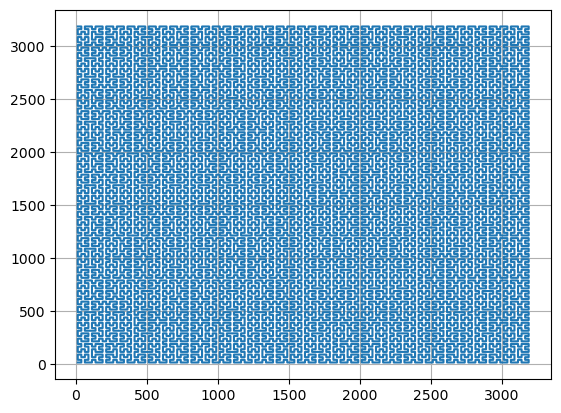

In [230]:
import matplotlib.pylab as plt
plt.plot(points[:, 0], points[:, 1])
plt.grid()

In [231]:
def get_direction(p0, p1):
    if p0[0] < p1[0] and p0[1] == p1[1]:
        return np.array([1, 0])
    elif p0[0] == p1[0] and p0[1] < p1[1]:
        return np.array([0, 1])
    elif p0[0] > p1[0] and p0[1] == p1[1]:
        return np.array([-1, 0])
    elif p0[0] == p1[0] and p0[1] > p1[1]:
        return np.array([0, -1])
    raise NotImplementedError

In [232]:
def angle_to_vector(angle):
    theta = np.deg2rad(angle)
    size = 1 / np.cos(np.deg2rad(angle % 90))
    return [np.cos(theta) * size, np.sin(theta) * size]

In [233]:
right_edges = []
left_edges = []
width = 4

for i in range(len(points)):
    
    if i == 0:
        p_curr = points[i]
        p_next = points[i + 1]
        prev_direction = get_direction(p_curr, p_next)
    else:
        p_prev = points[i - 1]
        p_curr = points[i]
        prev_direction = get_direction(p_prev, p_curr)

    if i == len(points) - 1:
        p_prev = points[i - 1]
        p_curr = points[i]
        next_direction = get_direction(p_prev, p_curr)
    else:
        p_curr = points[i]
        p_next = points[i + 1]
        next_direction = get_direction(p_curr, p_next)

    added_vector = prev_direction + next_direction
    right_theta = np.arctan2(*(added_vector[::-1])) - np.pi / 2
    left_theta = np.arctan2(*(added_vector[::-1])) + np.pi / 2
    right_angle = np.rad2deg(right_theta)
    left_angle = np.rad2deg(left_theta)

    d_right = angle_to_vector(right_angle)
    d_left = angle_to_vector(left_angle)
    right_edges.append([
        p_curr[0] + width * d_right[0],
        p_curr[1] + width * d_right[1]
    ])
    left_edges.append([
        p_curr[0] + width * d_left[0],
        p_curr[1] + width * d_left[1]
    ])
right_edges = np.array(right_edges)
left_edges = np.array(left_edges)

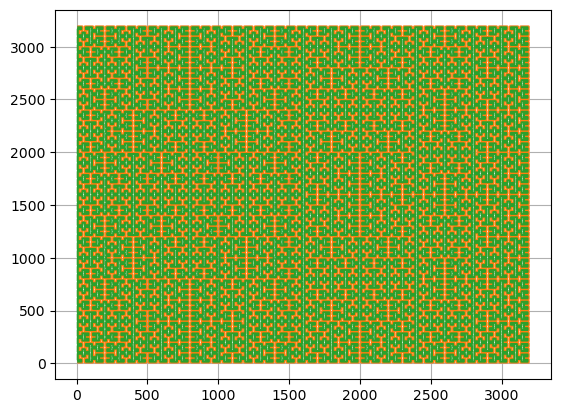

In [234]:
import matplotlib.pylab as plt
plt.plot(points[:, 0], points[:, 1])
plt.plot(right_edges[:, 0], right_edges[:, 1])
plt.plot(left_edges[:, 0], left_edges[:, 1])

plt.grid()

In [235]:
import numpy as np
import lanelet2
from lanelet2.core import Lanelet, Point3d, LineString3d
from lanelet2.io import write
from lanelet2.projection import (UtmProjector, MercatorProjector)

In [236]:
counter = 0
prev_node_right = Point3d(lanelet2.core.getId(), right_edges[counter][0], right_edges[counter][1], 0)
prev_node_left = Point3d(lanelet2.core.getId(), left_edges[counter][0], left_edges[counter][1], 0)

lmap = lanelet2.core.LaneletMap()

while True:
    counter += 1
    if counter >= len(points):
        break
    next_node_right = Point3d(lanelet2.core.getId(), right_edges[counter][0], right_edges[counter][1], 0)
    next_node_left = Point3d(lanelet2.core.getId(), left_edges[counter][0], left_edges[counter][1], 0)

    way_right = LineString3d(lanelet2.core.getId(), [prev_node_right, next_node_right])
    way_left = LineString3d(lanelet2.core.getId(), [prev_node_left, next_node_left])
    way_right.attributes['type'] = 'line_thin'
    way_right.attributes['subtype'] = 'solid'
    way_left.attributes['type'] = 'line_thin'
    way_left.attributes['subtype'] = 'solid'

    lanelet = Lanelet(lanelet2.core.getId(), way_left, way_right)
    lanelet.attributes['type'] = 'lanelet'
    lanelet.attributes['subtype'] = 'road'
    lanelet.attributes['speed_limit'] = '40'
    lanelet.attributes['location'] = 'urban'
    lanelet.attributes['one_way'] = 'yes'

    lmap.add(lanelet)

    prev_node_right = next_node_right
    prev_node_left = next_node_left


In [237]:
output_file = "/home/minoda/data/maps/dummy-large-map/lanelet2_map.osm"
projector = UtmProjector(lanelet2.io.Origin(35.619010, 139.78035))
lanelet2.io.write(output_file, lmap, projector)

In [238]:
length = square_size * 2 ** order
length

409600

In [239]:
4 ** order

16384